In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 로드

In [2]:
df = pd.read_csv('./train.csv')
df['시점'] = pd.to_datetime(df['시점'], format='%Y-%m-%d %H')
df.set_index('시점', inplace=True)
df

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


In [3]:
test = pd.read_csv('./test.csv')
test['시점'] = pd.to_datetime(test['시점'], format='%Y-%m-%d %H')
test.set_index('시점', inplace=True)
test

,구분
시점,
2019-01-01 00:00:00,A
2019-01-01 01:00:00,A
2019-01-01 02:00:00,A
2019-01-01 03:00:00,A
2019-01-01 04:00:00,A
...,...
2019-03-31 19:00:00,H
2019-03-31 20:00:00,H
2019-03-31 21:00:00,H


# 함수 및 상수 선언

In [4]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    X_test = X_train[2000:]             
    y_test = y_train[2000:]
    
    X_train = X_train[:2000]           
    y_train = y_train[:2000]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (2000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
            
    return [X_train, y_train, X_test, y_test]

In [5]:
seq_len = 20

# 예측모델 싱행

In [6]:
# 0시부터 23시까지 예측 후 결합  
D = pd.DataFrame()

for i in range(0,24):
    df_Dh = df[(df['구분'] == 'D') & (df.index.hour == i)]
    df_Dh.drop(columns='구분', inplace=True)

    scaler = sklearn.preprocessing.MinMaxScaler()
    df_Dh['공급량']=scaler.fit_transform(df_Dh['공급량'].values.reshape(-1,1))

    X_train, y_train, X_test, y_test = load_data(df_Dh, seq_len)

    lstm_model = Sequential()

    lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
    lstm_model.add(Dropout(0.15))

    lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
    lstm_model.add(Dropout(0.15))

    lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
    lstm_model.add(Dropout(0.15))

    lstm_model.add(Dense(1))

    print('----------구분: D, 시간: %d----------' %i)
    
    lstm_model.compile(optimizer="adam",loss="MAE")
    lstm_model.fit(X_train, y_train, epochs=15, batch_size=1000)

    lstm_predictions = lstm_model.predict(X_test)

    lstm_score = r2_score(y_test,lstm_predictions)    

    test_Dh = test[(test['구분'] == 'D') & (test.index.hour == i)]
    test_Dh.drop(columns='구분', inplace=True)

    test_Dh['공급량'] = np.nan

    Dh = df_Dh.append(test_Dh)

    for j in range(len(test_Dh)):
        pred = lstm_model.predict(np.reshape(np.array(Dh.dropna()[len(Dh.dropna())-20:]), (1, 20, 1)))
        Dh.iloc[len(Dh.dropna())] = pred

    Dh['공급량'] = scaler.inverse_transform(Dh)

    D = D.append(Dh)

D['구분'] = 'D'

----------구분: D, 시간: 0----------
Epoch 1/15
2/2 [==============================] - 3s 121ms/step - loss: 0.2738
Epoch 2/15
2/2 [==============================] - 0s 136ms/step - loss: 0.2012
Epoch 3/15
2/2 [==============================] - 0s 131ms/step - loss: 0.1481
Epoch 4/15
2/2 [==============================] - 0s 126ms/step - loss: 0.1118
Epoch 5/15
2/2 [==============================] - 0s 125ms/step - loss: 0.1141
Epoch 6/15
2/2 [==============================] - 0s 127ms/step - loss: 0.1048
Epoch 7/15
2/2 [==============================] - 0s 125ms/step - loss: 0.0801
Epoch 8/15
2/2 [==============================] - 0s 130ms/step - loss: 0.0745
Epoch 9/15
2/2 [==============================] - 0s 137ms/step - loss: 0.0760
Epoch 10/15
2/2 [==============================] - 0s 126ms/step - loss: 0.0645
Epoch 11/15
2/2 [==============================] - 0s 141ms/step - loss: 0.0627
Epoch 12/15
2/2 [==============================] - 0s 125ms/step - loss: 0.0694
Epoch 13/15
2/2 

In [7]:
# 생성된 D 확인
D

,공급량,구분
시점,,
2013-01-01 00:00:00,1434.516000,D
2013-01-02 00:00:00,1291.316000,D
2013-01-03 00:00:00,1664.996000,D
2013-01-04 00:00:00,1688.276000,D
2013-01-05 00:00:00,1695.316000,D
...,...,...
2019-03-27 23:00:00,372.688490,D
2019-03-28 23:00:00,367.368747,D
2019-03-29 23:00:00,362.148931,D


In [8]:
# 시점으로 오름차순 정렬
D = D.sort_index()
D

,공급량,구분
시점,,
2013-01-01 00:00:00,1434.516000,D
2013-01-01 01:00:00,1345.636000,D
2013-01-01 02:00:00,1270.756000,D
2013-01-01 03:00:00,1322.036000,D
2013-01-01 04:00:00,1421.956000,D
...,...,...
2019-03-31 19:00:00,694.185608,D
2019-03-31 20:00:00,536.907472,D
2019-03-31 21:00:00,543.700107,D


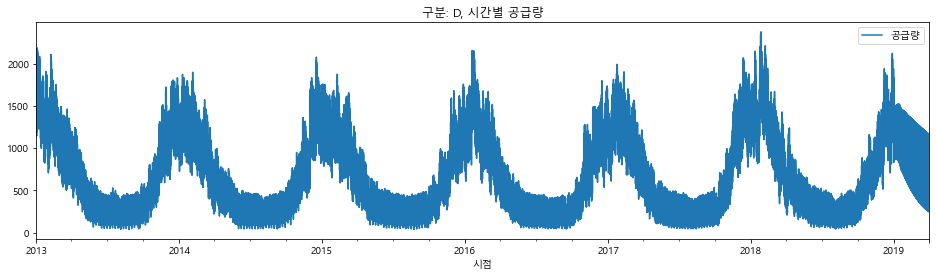

In [9]:
# 생성된 D 시각화
D.plot(figsize=(16,4),legend=True)

plt.title('구분: D, 시간별 공급량')

plt.show()

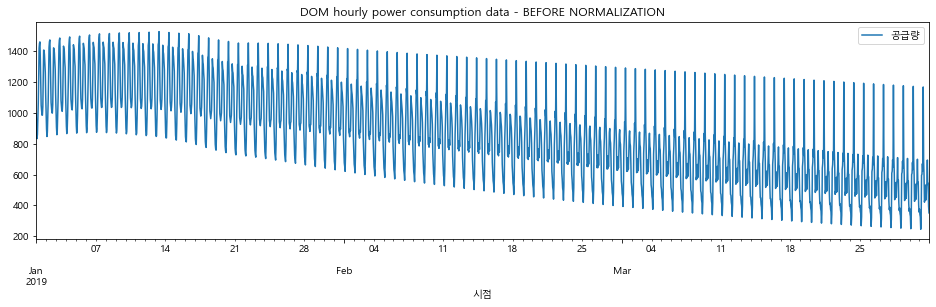

In [10]:
# 생성된 D 예측부분 시각화
D['2019-1-1':'2019-3-31'].plot(figsize=(16,4),legend=True)

plt.title('구분: D, 시간별 공급량')

plt.show()